# Entrainement d'un modèle d'IA bidon pour ajouter dans l'appli

## Récupération des données depuis la database

In [5]:
import sqlite3

database_path = '../db.sqlite3'
conn = sqlite3.connect(database_path)

In [6]:
query = "SELECT * FROM application_meddata"

In [7]:
import pandas as pd

df = pd.read_sql(query, conn)
conn.close()

In [8]:
df.head()

,id,date,poids,tourTaille,freqCard,systMatin,systSoir,diastMatin,diastSoir,symptCardio,...,douleurPoitrine,conflits,diffLever,sentimentHorsCtrl,diffActivite,retrait,diffEndormir,diffRemettreEvent,mainsMoites,anonymousID_id
0,1,2023-10-02,70.5,90.2,72,120,118,78,80,Perte de connaissance,...,0,0,1,0,1,1,0,0,1,P01
1,2,2023-10-09,70.7,90.0,73,124,122,80,82,None,...,0,0,1,0,0,0,0,0,0,P01
2,3,2023-10-16,70.9,90.1,74,121,120,79,81,None,...,0,0,1,0,0,1,0,1,1,P01
3,4,2023-10-02,68.0,88.0,70,118,120,76,78,None,...,0,0,1,0,5,0,1,0,0,P02
4,5,2023-10-09,68.2,88.2,71,120,118,78,80,None,...,1,0,0,0,1,1,1,0,5,P02


## Exploration rapide

In [9]:
import matplotlib as plt

<Axes: xlabel='poids', ylabel='tourTaille'>

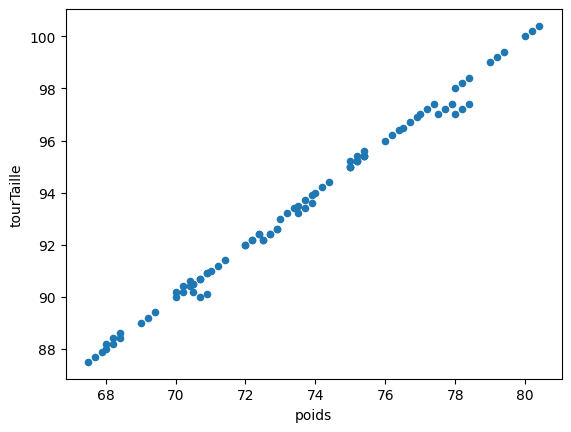

In [11]:
# Create scatter plot with x and y data from the DataFrame
df.plot.scatter(x='poids', y='tourTaille')

## Entrainement d'un modele de regression

In [20]:
from  sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [28]:
# set training data
X = df["poids"].values.reshape(-1, 1)
y = df["tourTaille"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [26]:
# fit the model
reg = ElasticNet(random_state=0).fit(X_train, y_train)

In [33]:
# get prediction
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("Test score - R2:", r2)

Test score - R2: 0.9871493680041147


## Stocker le modèle dans MLFlow

In [ ]:
%pip install mlflow

In [32]:
import mlflow
from mlflow.models import infer_signature

# set l'uri pour envoyer le modele
print("set_tracking uri")
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080") # port 8090 en local

print("set_experiment")
mlflow.set_experiment("Regression poids tour de taille Doctolib")

2024/01/08 19:54:25 INFO mlflow.tracking.fluent: Experiment with name 'Regression poids tour de taille Doctolib' does not exist. Creating a new experiment.


set_tracking uri
set_experiment


<Experiment: artifact_location='mlflow-artifacts:/122245147476016265', creation_time=1704740065747, experiment_id='122245147476016265', last_update_time=1704740065747, lifecycle_stage='active', name='Regression poids tour de taille Doctolib', tags={}>

In [34]:
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params({"random_state" : 0})

    # Log the loss metric
    mlflow.log_metric("r2", r2)
 
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Our model")

    # Infer the model signature
    signature = infer_signature(X_train, reg.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=ElasticNet,
        artifact_path="meddata",
        signature=signature,
        input_example=X_train,
        registered_model_name="ElasticNet_v1",
    )

Successfully registered model 'ElasticNet_v1'.
2024/01/08 19:58:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ElasticNet_v1, version 1
Created version '1' of model 'ElasticNet_v1'.
